In [191]:
#from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
from PIL import Image
import requests
import torch.hub
import time
import pickle
import math
from torch.autograd import Variable

from utils import matching, stats, proggan, nethook, zdataset

In [192]:
device = torch.device('cuda:0')

In [193]:
clipmodel, preprocess = clip.load("RN50", device=device)
clip_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
for p in clipmodel.parameters(): 
    p.data = p.data.float() 

In [194]:
text = clip.tokenize([ "A dog that is happy outside"]).to(device)


In [195]:
image = preprocess(Image.open("./golden_retriever/image/golden_retriever.png")).unsqueeze(0).to(device)

In [196]:
text = clip.tokenize(["dog"]).to(device)
text_features = clipmodel.encode_text(text).detach()
#text_features = text_features / text_features.norm(dim=1, keepdim=True)
#logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07)).exp().detach()

In [197]:
inputs = Variable(torch.randn(1,3,224,224).to(device), requires_grad = True)
optim = torch.optim.Adam([inputs], lr=0.01, betas=(0.5, 0.999))  

In [198]:
from torch.nn import CosineSimilarity
cossim = CosineSimilarity(dim=0, eps=1e-6)

In [199]:
for epoch in range(0,10):
    optim.zero_grad()
    
    image_features = clipmodel.encode_image(inputs)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    loss = -1*image_features @ text_features.t()
    #print(loss)
    #loss = cossim(image_features.flatten(), text_features.flatten())
    
    if (epoch+1)%100 == 0:
        print("E:", epoch+1, "loss:", loss)
        
    loss.backward()
    optim.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


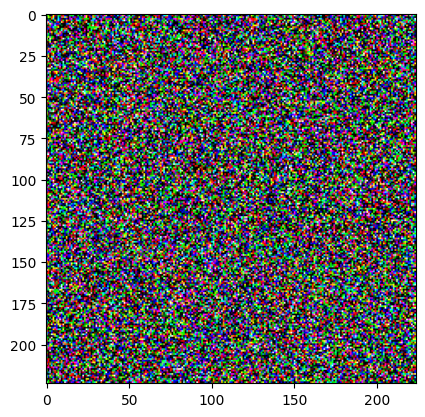

In [200]:
plt.imshow(torch.permute(inputs[0].cpu().detach(), (1,2,0)))

In [201]:
clip

<module 'clip' from '/home/patrick.koller/.local/lib/python3.8/site-packages/clip/__init__.py'>

In [202]:
clipmodel, preprocess = clip.load("RN50", device=device)

In [203]:
text = clip.tokenize(["dog", "cat", "noise", "rainbow", "color"]).to(device)


image_features = clipmodel.encode_image(inputs)
text_features = clipmodel.encode_text(text)


image_features = image_features / image_features.norm(dim=1, keepdim=True)
text_features = text_features / text_features.norm(dim=1, keepdim=True)
loss = image_features @ text_features.t()

print(loss)




logits_per_image, logits_per_text = clipmodel(inputs, text)
probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
print("Label probs:", probs)

tensor([[0.2712, 0.2377, 0.2537, 0.2070, 0.2178]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward0>)
Label probs: [[0.825    0.02867  0.1411   0.001341 0.003881]]


In [204]:
from utils import matching

In [205]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [206]:
asdf = []

for p in clipmodel.parameters():
    asdf.append(p)

In [207]:
clipmodel

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [208]:
clipmodel, preprocess = clip.load("RN50", device=device)
clip_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
for p in clipmodel.parameters(): 
    p.data = p.data.float() 
    
clipmodel = nethook.InstrumentedModel(clipmodel)
clipmodel.retain_layers(clip_layers)

In [215]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [209]:
#inputs = image
_ = clipmodel.model.encode_image(inputs)
clip_activs = {}
for layer in clip_layers:
    clip_activs[layer] = []
    clip_activation = clipmodel.retained_layer(layer, clear = True)
    clip_activs[layer].append(clip_activation)

In [210]:
len(clip_activs['visual.layer4'])

1

In [211]:
clip_activs['visual.layer1'][0].shape

torch.Size([1, 256, 56, 56])

In [212]:
clip_activs['visual.layer2'][0].shape

torch.Size([1, 512, 28, 28])

In [213]:
clip_activs['visual.layer3'][0].shape

torch.Size([1, 1024, 14, 14])

In [214]:
clip_activs['visual.layer4'][0].shape

torch.Size([1, 2048, 7, 7])

In [216]:
clip_activs['visual.layer1'][0][0][0]

tensor([[0.2731, 0.0073, 0.3626,  ..., 0.0000, 0.0000, 0.7894],
        [0.0000, 0.0000, 0.6242,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.6467, 0.6606,  ..., 0.0000, 0.0000, 0.3791],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5553, 1.9137]],
       device='cuda:0')

In [217]:
clip_activs['visual.layer2'][0][0][0]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3530e-01, 2.0526e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6624e-01, 0.0000e+00, 0.0000e+00,
         3.0975e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3792e-01, 5.2295e-01, 5.3846e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6875e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5810e-01, 3.9364e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.3943e-01, 0.0000e+00, 6.2553e-01, 0.0000e+00, 0.0000e+00, 2.1696e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5230e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.9209e-01, 0.0000e+00, 8.4009e-01, 1.1784e+00, 1.1469e+00,
         1.8881e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5143e-01,
         0.0000e+00, 0.0000e+00, 5.0327e-01, 0.0000e+00, 0.0000e+00, 2.394

In [222]:
clip_activs['visual.layer3'][0][0][0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

In [148]:
clip_activs['visual.layer4'][0][0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0927, 0.0000, 0.2539, 0.0000, 0.0000, 0.0000],
        [0.3031, 0.0000, 0.0000, 0.0774, 0.1294, 0.1678, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1289, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [146]:
clip_activation.shape

torch.Size([1, 2048, 7, 7])

In [228]:
torch.permute(clip_activs[layer][0], (1,0,2,3)).contiguous().shape

torch.Size([2048, 1, 7, 7])

In [233]:
clip_activs[layer][0].view(clip_activs[layer][0].shape[0], -1).shape

torch.Size([1, 100352])

In [164]:
clip_stats = []
for layer in clip_layers:
    clip_activs[layer] = torch.cat(clip_activs[layer], 0)
    clip_activs[layer] = torch.permute(clip_activs[layer], (1,0,2,3)).contiguous()
    clip_activs[layer] = clip_activs[layer].view(clip_activs[layer].shape[0], -1)
    clip_stats.append([torch.mean(clip_activs[layer], dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(clip_activs[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])


In [165]:
clip_activs['visual.layer4'].shape

torch.Size([2048, 49])

In [166]:
(clip_stats[0])[0].shape

torch.Size([1, 256, 1, 1])

In [167]:
clip_means = []
clip_stds = []
for iii, layer in enumerate(clip_stats):
    clip_means.append(clip_stats[iii][0].flatten().unsqueeze(0))
    clip_stds.append(clip_stats[iii][1].flatten().unsqueeze(0))

clip_means = torch.cat(clip_means,1)
clip_stds = torch.cat(clip_stds,1)

In [168]:
clip_means.shape

torch.Size([1, 3840])

In [169]:
clip_stds.shape

torch.Size([1, 3840])

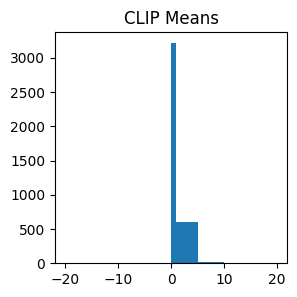

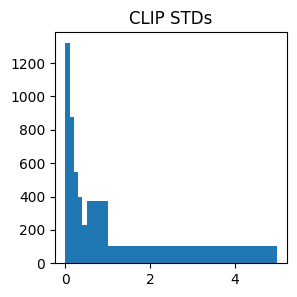

In [170]:
fig, ax = plt.subplots(figsize =(3, 3))
ax.hist(clip_means.cpu(), bins = [-20, -10, -5, -1, 0, 1, 5, 10, 20])
plt.title("CLIP Means")
plt.show()
    
    
fig, ax = plt.subplots(figsize =(3, 3))
ax.hist(clip_stds.cpu(), bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5,1, 5])
plt.title("CLIP STDs")
# plt.xticks(np.arange(0, 1, 0.1), size =5)
plt.show()

In [171]:
val, clipidx = torch.topk(clip_means, k=50)
print(val)
print(clipidx)

tensor([[16.5897, 10.1941,  8.9085,  8.0655,  7.9657,  7.8943,  7.4904,  7.2447,
          7.1136,  6.7408,  6.4363,  6.4356,  6.0755,  5.9240,  5.8896,  5.6152,
          5.5905,  5.5786,  5.4602,  5.4090,  5.2746,  4.9940,  4.7204,  4.6925,
          4.6579,  4.5294,  4.4876,  4.4235,  4.3744,  4.3537,  4.1675,  4.1467,
          4.1210,  4.1120,  4.1108,  4.0778,  4.0626,  4.0377,  4.0174,  3.9999,
          3.9961,  3.9560,  3.9501,  3.9458,  3.9077,  3.9055,  3.8778,  3.8435,
          3.8127,  3.7972]], device='cuda:0', dtype=torch.float64)
tensor([[1109, 1246, 1278, 1607,  924, 1456, 1191, 1397, 1039, 1000,  619,  873,
          863, 1219, 3608, 1673, 1308, 1164, 1455,   83,  437,  920, 2924, 1309,
          521, 3657,  591,  488,  936,  756, 1223,  353, 1336, 1300, 1916, 1430,
          465, 1293,  293,  862,  422,  495,  654,   82, 1464,  794, 1029, 1131,
          788,  195]], device='cuda:0')


In [172]:
all_clip_layers = {}
for jjj, clip_activ in enumerate(list(clip_activs.values())):
    print(clip_activ.shape)
    all_clip_layers[clip_layers[jjj]] = clip_activ.shape[0]

torch.Size([256, 3136])
torch.Size([512, 784])
torch.Size([1024, 196])
torch.Size([2048, 49])


In [235]:
all_clip_layers

{'visual.layer1': 256,
 'visual.layer2': 512,
 'visual.layer3': 1024,
 'visual.layer4': 2048}

In [173]:
from utils import layers
idx = layers.find_act(2924, all_clip_layers)
#idx = layers.find_act(clipidx[0][0].item(), all_clip_layers)

In [272]:
layers_list = list(all_clip_layers)
layers_list

layer = 0
counter =0

act_num = 2924

In [278]:
all_clip_layers

{'visual.layer1': 256,
 'visual.layer2': 512,
 'visual.layer3': 1024,
 'visual.layer4': 2048}

In [281]:
2924 - (256+512+1024+2048) + 2048

1132

In [274]:
all_clip_layers[layers_list[layer-1]]

2048

In [ ]:
def find_act(act_num, net_dict):
    layers_list = list(net_dict)
    
    layer = 0
    counter =0
    
    while act_num >= counter:
        layer +=1
        counter += net_dict[layers_list[layer-1]]
        
        
    act = act_num-counter+net_dict[layers_list[layer-1]]
    
    del layers_list
    torch.cuda.empty_cache()
    return (layer-1), act

In [174]:
idx

(3, 1132)

In [175]:
all_clip_layers

{'visual.layer1': 256,
 'visual.layer2': 512,
 'visual.layer3': 1024,
 'visual.layer4': 2048}

In [176]:
inputs = image
_ = clipmodel.model.encode_image(inputs)
clip_activs = {}
for layer in clip_layers:
    clip_activs[layer] = []
    clip_activation = clipmodel.retained_layer(layer, clear = True)
    clip_activs[layer].append(clip_activation)

In [177]:
clip_activs['visual.layer3'][0].shape

torch.Size([1, 1024, 14, 14])

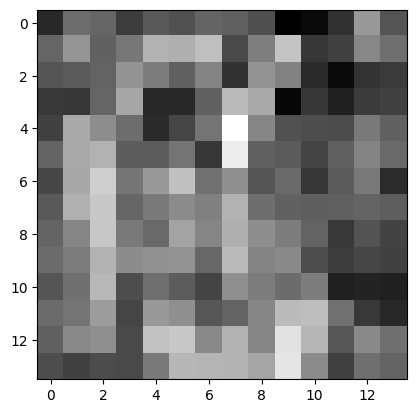

In [178]:
plt.imshow(clip_activs['visual.layer3'][0][0,341].cpu().detach(),cmap="gray")

In [179]:
torch.mean(clip_activs['visual.layer3'][0][0,341])

tensor(16.7876, device='cuda:0')

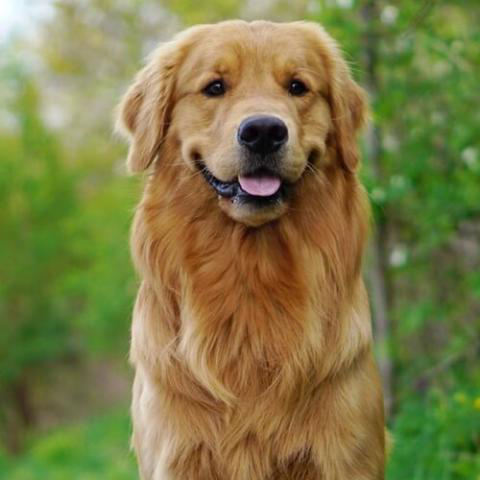

In [180]:
Image.open("./golden_retriever/image/golden_retriever.png")

In [181]:
#inputs = image
_ = clipmodel.model.encode_image(inputs)
clip_activs = {}
for layer in clip_layers:
    clip_activs[layer] = []
    clip_activation = clipmodel.retained_layer(layer, clear = True)
    clip_activs[layer].append(clip_activation)

In [182]:
clip_stats = []
for layer in clip_layers:
    clip_activs[layer] = torch.cat(clip_activs[layer], 0)
    clip_activs[layer] = torch.permute(clip_activs[layer], (1,0,2,3)).contiguous()
    clip_activs[layer] = clip_activs[layer].view(clip_activs[layer].shape[0], -1)
    a,_ = torch.max(clip_activs[layer], dim=-1)
    a = a.unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
    clip_stats.append([a])


In [263]:
torch.max(torch.tensor([[1,2],[3,4]]), dim=-1)

torch.return_types.max(
values=tensor([2, 4]),
indices=tensor([1, 1]))

In [183]:
clip_max = []
for iii, layer in enumerate(clip_stats):
    clip_max.append(clip_stats[iii][0].flatten().unsqueeze(0))
    
clip_max = torch.cat(clip_max,1)


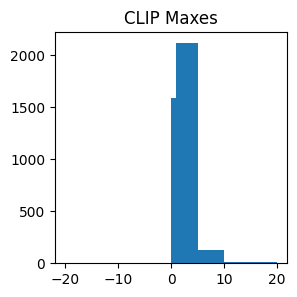

In [184]:
fig, ax = plt.subplots(figsize =(3, 3))
ax.hist(clip_max.cpu(), bins = [-20, -10, -5, -1, 0, 1, 5, 10, 20])
plt.title("CLIP Maxes")
plt.show()


In [185]:
val, clipidx = torch.topk(clip_max, k=50)
print(val)
print(clipidx)

tensor([[34.5698, 25.4798, 17.6181, 17.5030, 13.8352, 13.7741, 13.3642, 12.9616,
         11.6962, 11.1802, 10.6735, 10.4728, 10.4329, 10.1710, 10.0177,  9.9805,
          9.6615,  9.5037,  9.2244,  9.1939,  9.0235,  8.9785,  8.9752,  8.8914,
          8.8863,  8.8619,  8.7888,  8.6571,  8.6456,  8.4996,  8.4505,  8.4454,
          8.4154,  8.3841,  8.2909,  7.9789,  7.9016,  7.8301,  7.8218,  7.8041,
          7.7545,  7.6893,  7.6229,  7.5768,  7.5567,  7.5471,  7.5171,  7.5152,
          7.4812,  7.3461]], device='cuda:0')
tensor([[2800, 2332, 1109, 2774, 2213, 3460, 3163, 1107, 3640, 1278, 1246, 1937,
         1843, 2296, 2600, 3255, 1607,  924, 2620, 2153, 2483,  775, 1456, 2101,
         3177, 2173, 2470, 2687, 2869, 2326, 3725, 3545,  738, 1397, 3796, 1191,
          619, 1039, 3403, 1888, 1851, 2973, 3522, 1000, 2113, 3145, 1308, 3256,
         3684, 3056]], device='cuda:0')


In [186]:
layers.find_act(3168, all_clip_layers)

(3, 1376)